# Imports, device and seeding

In [1]:
# --- Standard libs ---
import os, pickle
import math
import random
from dataclasses import dataclass
from typing import Dict, Any
import time

# --- Scientific stack ---
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- ACORL and RL ---
from acorl.envs.seeker.seeker import SeekerEnv, SeekerEnvConfig

# --- Own Code ---
from MCTS import MCTSPlanner
from network import SeekerAlphaZeroNet
from utils import (
    ReplayBufferHybrid,
    collect_one_episode_hybrid,
    train_step_mle,
    train_step_mcts_distill,
    train_step_hybrid,
    run_eval_episodes,
    run_debug_eval_episode,
    grow_replay,
)
from plot_utils import (
#    decode_obs,
    plot_seeker_obs,
    plot_seeker_trajectory,
#    collect_tree_edges,
    plot_mcts_tree_xy,
    plot_mcts_tree_xy_limited,
    inspect_debug_trace_xy,
    plot_dbg_step,
)

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# --- Reproducibility ---
def set_global_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


RNG_SEED = 42
set_global_seeds(RNG_SEED)

EVAL_DIR = "eval_traces"
s = time.strftime("%d%m%Y_%H%M%S", time.localtime())
os.makedirs(EVAL_DIR+"_"+s, exist_ok=True)

Using device: cpu


# Config

## baseline config
### Comments are explaining what each parameter does in general, but also mixed with comments that explain behavious of this specific configuration

In [2]:
@dataclass
class Config:
    # ========================
    # Environment
    # ========================
    max_episode_steps: int = 200  # max steps in environment before cut off (goal not reached, obstacle not crashed into --> prevent forever stepping)

    # ========================
    # MCTS core
    # ========================
    num_simulations: int = 400    # Number of MCTS simulations per real environment step
    cpuct: float = 1.5            # Exploration vs exploitation tradeoff in PUCT; Higher -> more exploration guided by policy prior
    max_depth: int = 64           # Safety cap on tree depth during a simulation

    # For root action selection / Action sampling temperature at root
    # >1.0 = more stochastic, 1.0 = proportional to visits, ~0 = greedy
    temperature: float = 1.0

    # ========================
    # Progressive Widening
    # ========================
    pw_k: float = 2.0
    # Controls how many actions are allowed per node:
    #   K_max = pw_k * N(s)^pw_alpha
    pw_alpha: float = 0.5
    # Growth rate of branching factor
    # 0.5 is common; smaller = more conservative expansion

    # ========================
    # Action sampling (baseline, non-fancy, but no duplicates)
    # ========================
    # --- Uniform warmstart ---
    # No uniform warmstart, no diversity scoring
    K_uniform_per_node: int = 8
    # First K children per node are sampled uniformly in [-1,1]^2
    # Set to 0 to disable
    warmstart_iters: int = 20
    # Number of *training iterations* during which ALL nodes use uniform sampling
    # 0 disables global warmstart; use this if you want uniform sampling only early in training

    # --- Novelty reject (hard deduplication) ---
    # Deduplicate actions (keep this ON to satisfy “no duplicate actions”)
    novelty_eps: float = 1e-3      # small but > 0
    # Minimum distance between actions to be considered "new"
    # In [-1,1]^2, values around 0.05–0.15 are reasonable
    # Set <=0 to disable
    novelty_metric: str = "l2"
    # Distance metric for novelty check:
    # "linf" = max(|dx|, |dy|)  (good for box action spaces)
    # "l2"   = Euclidean distance

    # --- Diversity scoring (soft repulsion) ---
    # Disable candidate scoring / diversity
    num_candidates: int = 1
    # Number of candidate actions sampled before choosing the best
    # <=1 disables diversity scoring
    diversity_lambda: float = 0.0
    # Strength of diversity penalty
    # Higher -> stronger push away from already-sampled actions
    # Set <=0 to disable
    diversity_sigma: float = 0.25  # unused
    # Length scale for diversity penalty
    # Roughly: how far actions must be before they stop "repelling" each other
    policy_beta: float = 1.0       # unused
    # Weight of policy log-probability in candidate scoring
    # Higher -> follow policy more closely
    # Lower -> prioritize diversity more

    # --- Resampling control ---
    max_resample_attempts: int = 16
    # How many times expansion may retry to find a novel action
    # If all fail, expansion is declined and MCTS falls back to selection
    
    # ========================
    # Training
    # ========================
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-4
    train_steps_per_iter: int = 200    # Gradient updates per outer iteration

    # (Only used by our baseline loss function)
    value_loss_weight: float = 1.0
    policy_loss_weight: float = 1.0  # applies to mu/log_std regression

    # ========================
    # Data collection
    # ========================
    collect_episodes_per_iter: int = 10     # Number of real env episodes collected per training iteration
    replay_buffer_capacity: int = 4*batch_size
    gamma_mcts: float = 0.975      # Discount factor for return backup in MCTS
    gamma_mc = 0.9

    # ========================
    # Logging / evaluation
    # ========================
    eval_every: int = 25
    eval_episodes: int = 50   # use 10 fixed seeds for smoother eval curves


cfg = Config()


## Sanity test

In [3]:
from pprint import pprint
pprint(cfg)

Config(max_episode_steps=200,
       num_simulations=400,
       cpuct=1.5,
       max_depth=64,
       temperature=1.0,
       pw_k=2.0,
       pw_alpha=0.5,
       K_uniform_per_node=8,
       warmstart_iters=20,
       novelty_eps=0.001,
       novelty_metric='l2',
       num_candidates=1,
       diversity_lambda=0.0,
       diversity_sigma=0.25,
       policy_beta=1.0,
       max_resample_attempts=16,
       batch_size=128,
       learning_rate=0.0003,
       weight_decay=0.0001,
       train_steps_per_iter=200,
       value_loss_weight=1.0,
       policy_loss_weight=1.0,
       collect_episodes_per_iter=10,
       replay_buffer_capacity=512,
       gamma_mcts=0.975,
       eval_every=25,
       eval_episodes=50)


# Create env_real, env_sim, dims (for network), and step_fn (for MCTSPlanner)

In [4]:
# --- Env config ---
env_config = SeekerEnvConfig(randomize=True, num_obstacles=1)

# --- Real environment for rollouts / data collection ---
env_real = SeekerEnv(**env_config.model_dump(exclude={"id"}))
obs0, info0 = env_real.reset()

obs_dim = env_real.observation_space.shape[0]
action_dim = env_real.action_space.shape[0]

print("obs_dim:", obs_dim, "action_dim:", action_dim)
print("action_space:", env_real.action_space)

# --- Simulation environment for MCTS step_fn ---
env_sim = SeekerEnv(**env_config.model_dump(exclude={"id"}))

# --- evaluation environment for evaluation during training ---
env_eval = SeekerEnv(**env_config.model_dump(exclude={"id"}))


def set_env_state_from_obs(sim_env: SeekerEnv, obs: np.ndarray):
    """
    Overwrite SeekerEnv internal state to match the flat observation vector.

    obs layout (from your old notebook):
      [agent_x, agent_y, goal_x, goal_y, (obs_x, obs_y, obs_r)*N]
    """
    obs = np.asarray(obs, dtype=sim_env._dtype)

    # agent and goal
    sim_env._agent_position = obs[0:2].copy()
    sim_env._goal_position = obs[2:4].copy()

    # obstacles
    obstacles = obs[4:].reshape(-1, 3)
    sim_env._obstacle_position = obstacles[:, 0:2].copy()
    sim_env._obstacle_radius = obstacles[:, 2].copy()

def step_fn(state: np.ndarray, action: np.ndarray):
    """
    MCTS transition function: set env_sim to `state`, take `action`, return next_state/reward/done/info.
    Returns: next_state, reward, done, info  (matching MCTSPlanner expectations)
    """
    set_env_state_from_obs(env_sim, state)

    action = np.asarray(action, dtype=env_sim._dtype)
    next_obs, reward, terminated, truncated, info = env_sim.step(action)
    done = bool(terminated or truncated)

    return next_obs, float(reward), done, info

obs_dim: 7 action_dim: 2
action_space: Box(-1.0, 1.0, (2,), float64)


# Instantiate neural network and optimizer

In [5]:
# --- Network ---
net = SeekerAlphaZeroNet(obs_dim=obs_dim, action_dim=action_dim).to(device)

# Optional: print one forward pass sanity
obs_t = torch.from_numpy(obs0).float().unsqueeze(0).to(device)
with torch.no_grad():
    mu_t, log_std_t, v_t = net(obs_t)

print("mu:", mu_t.cpu().numpy())
print("log_std:", log_std_t.cpu().numpy())
print("v:", v_t.item())

# --- Optimizer (we'll use later) ---
optimizer = optim.AdamW(net.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)

mu: [[-0.26337135 -0.13172348]]
log_std: [[ 0.45294833 -0.14332369]]
v: 0.02973608300089836


# Instantiate MCTSPlanner

In [6]:
planner = MCTSPlanner(
    net=net,
    device=str(device),
    step_fn=step_fn,
    num_simulations=cfg.num_simulations,
    cpuct=cfg.cpuct,
    gamma=cfg.gamma_mcts,
    pw_k=cfg.pw_k,
    pw_alpha=cfg.pw_alpha,
    max_depth=cfg.max_depth,
    temperature=cfg.temperature,
    rng=np.random.default_rng(RNG_SEED),
    
    K_uniform_per_node=cfg.K_uniform_per_node,
    warmstart_iters=cfg.warmstart_iters,
    novelty_eps=cfg.novelty_eps,
    novelty_metric=cfg.novelty_metric,
    num_candidates=cfg.num_candidates,
    diversity_lambda=cfg.diversity_lambda,
    diversity_sigma=cfg.diversity_sigma,
    policy_beta=cfg.policy_beta,
    max_resample_attempts=cfg.max_resample_attempts,
)

# Smoke test: one MCTS search, inspect root, pick action, step env_real

In [7]:
# Reset real env
obs, info = env_real.reset()

# Run one MCTS search from the current observation
root = planner.search(obs)

print("Root visit count N:", root.N)
print("Root children K:", len(root.children))

# Show a few children stats
for i, ch in enumerate(root.children[:5]):
    print(
        f"[{i}] N_sa={ch.N_sa:4d}  Q_sa={ch.Q_sa:+.4f}  "
        f"P_raw={ch.P_sa_raw:.3e}  P={ch.P_sa:.3f}  action={ch.action}"
    )

# Pick an action from MCTS policy (training=True samples from visit counts)
action = planner.act(root, training=True)
print("Chosen action:", action)

# Step the real environment once
next_obs, reward, terminated, truncated, info = env_real.step(action)
done = bool(terminated or truncated)

print("Step result -> reward:", reward, "done:", done)
print("Obs delta L2:", np.linalg.norm(next_obs - obs))


Root visit count N: 400
Root children K: 40
[0] N_sa=   3  Q_sa=-33.6293  P_raw=1.123e-01  P=0.033  action=[ 0.5479121  -0.12224312]
[1] N_sa=   6  Q_sa=-17.6155  P_raw=8.752e-02  P=0.026  action=[0.71719587 0.39473605]
[2] N_sa=  14  Q_sa=-3.0146  P_raw=4.341e-02  P=0.013  action=[-0.8116453  0.9512447]
[3] N_sa=   7  Q_sa=-15.8033  P_raw=7.721e-02  P=0.023  action=[0.5222794 0.5721286]
[4] N_sa=  14  Q_sa=-9.5765  P_raw=5.583e-02  P=0.016  action=[-0.25840396  0.85353   ]
Chosen action: [-0.98914033 -0.89668417]
Step result -> reward: -1.7583429241649728 done: False
Obs delta L2: 1.3350809324530617


In [8]:
# Show all children stats
for i, ch in enumerate(root.children):
    print(
        f"[{i}] N_sa={ch.N_sa:4d}  Q_sa={ch.Q_sa:+.4f}  "
        f"P_raw={ch.P_sa_raw:.3e}  P={ch.P_sa:.3f}  action={ch.action}"
    )

actions = np.stack([ch.action for ch in root.children], axis=0)
print("unique rows:", np.unique(actions, axis=0).shape[0], " / ", actions.shape[0])

[0] N_sa=   3  Q_sa=-33.6293  P_raw=1.123e-01  P=0.033  action=[ 0.5479121  -0.12224312]
[1] N_sa=   6  Q_sa=-17.6155  P_raw=8.752e-02  P=0.026  action=[0.71719587 0.39473605]
[2] N_sa=  14  Q_sa=-3.0146  P_raw=4.341e-02  P=0.013  action=[-0.8116453  0.9512447]
[3] N_sa=   7  Q_sa=-15.8033  P_raw=7.721e-02  P=0.023  action=[0.5222794 0.5721286]
[4] N_sa=  14  Q_sa=-9.5765  P_raw=5.583e-02  P=0.016  action=[-0.25840396  0.85353   ]
[5] N_sa=  11  Q_sa=-10.5992  P_raw=1.026e-01  P=0.030  action=[-0.1131716 -0.5455226]
[6] N_sa=   2  Q_sa=-49.2811  P_raw=1.100e-01  P=0.032  action=[ 0.5161755  -0.29094806]
[7] N_sa=   9  Q_sa=-13.3049  P_raw=7.088e-02  P=0.021  action=[-0.066558  -0.9123925]
[8] N_sa=   6  Q_sa=-17.8309  P_raw=9.686e-02  P=0.028  action=[-0.06088838 -0.6210573 ]
[9] N_sa=   2  Q_sa=-49.3703  P_raw=1.090e-01  P=0.032  action=[ 0.4005302  -0.37526673]
[10] N_sa=  10  Q_sa=-11.5294  P_raw=9.534e-02  P=0.028  action=[0.5738488  0.32970172]
[11] N_sa=  10  Q_sa=-11.6798  P_raw

# Tests

## Test randomization seed (reproducibility)

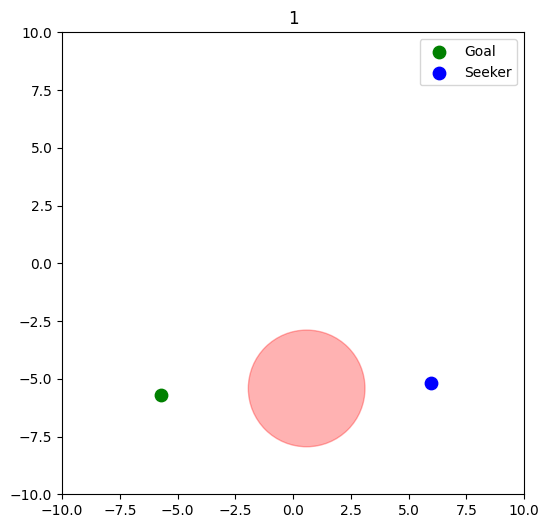

In [9]:
# number of obstacles this env actually has:
num_obstacles = (len(obs) - 4) // 3
# also just env._num_obstacles (?)

# reset real env
obs, info = env_real.reset()
plot_seeker_obs(obs, info, num_obstacles)

# randomize=True should give different positions over next two plots, but always same due to numpy rng seed

In [10]:
print(obs)

[ 5.98396753 -5.17789601 -5.72715059 -5.69871882  0.58691692 -5.41791639
  2.52576318]


In [11]:
# should be:
# [ 5.98396753 -5.17789601 -5.72715059 -5.69871882  0.58691692 -5.41791639
#   2.52576318]
obs == [5.98396753, -5.17789601, -5.72715059, -5.69871882, 0.58691692, -5.41791639, 2.52576318]

array([False, False, False, False, False, False, False])

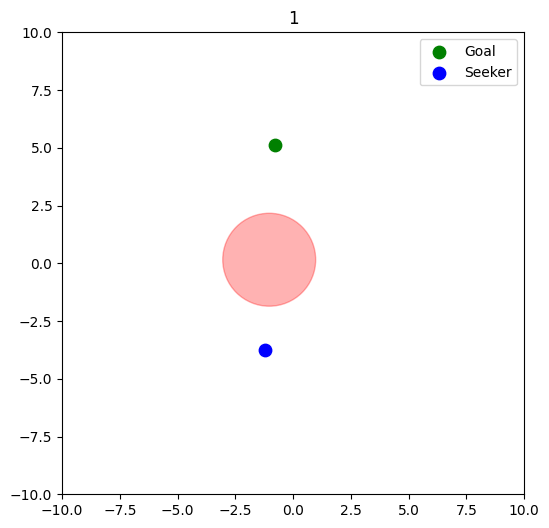

In [12]:
# reset real env -> different setup, but same different every time notebook is restarted ?
obs, info = env_real.reset()
plot_seeker_obs(obs, info, num_obstacles)

# randomize=True should give different positions over next two plots, but always same due to numpy rng seed

In [13]:
print(obs)

[-1.22498966 -3.75787548 -0.79074028  5.13316731 -1.03394827  0.15360326
  2.01160903]


In [14]:
# should be:
# [-1.22498966 -3.75787548 -0.79074028  5.13316731 -1.03394827  0.15360326
#   2.01160903]
obs == [-1.22498966, -3.75787548, -0.79074028, 5.13316731, -1.03394827, 0.15360326, 2.01160903]
# FAILS DUE TO ACTUALLY obs[0] (as an example) BEING -1.2249896644419165

array([False, False, False, False, False, False, False])

# create buffer, collect data, train, and log losses

## buffer and logging containers; schedules

In [15]:
# Buffer
replay = ReplayBufferHybrid(
    capacity=cfg.replay_buffer_capacity,
    obs_dim=obs_dim,
    action_dim=action_dim,
    K_max=32,
)

# Logging containers (easy to plot later)
logs = {
    "loss_total": [],
    "loss_value": [],
    "loss_policy": [],
    "loss_policy_distill": [],
    "loss_mu": [],
    "loss_log_std": [],
    "ep_return": [],
    "ep_length": [],
    "eval_return_mean": [],
    "eval_return_std": [],
    "eval_length_mean": [],
    "eval_length_succes": [],
    "eval_length_collision": [],
    "success_rate": [],
    "collision_rate": [],
    "max_step_rate": [],
    "iter_idx_eval": [],
}

In [16]:
## schedules (for later)

In [17]:
"""
# A simple schedule for gaussian regression weight λ
def lambda_gauss(iter_idx: int) -> float:
    # Example: off for first 10 iters, then ramp to 1.0 over 20 iters
    start = 10
    ramp = 20
    if iter_idx < start:
        return 0.0
    x = min(1.0, (iter_idx - start) / float(ramp))
    return float(x)  # ramps 0 -> 1


# Value target mixing schedule (optional)
def value_mix(iter_idx: int):
    # Example: start with MC a bit, then prefer MCTS
    # You can flip this if you want.
    w_mcts = 1.0
    w_mc = 0.0
    return w_mcts, w_mc
"""

'\n# A simple schedule for gaussian regression weight λ\ndef lambda_gauss(iter_idx: int) -> float:\n    # Example: off for first 10 iters, then ramp to 1.0 over 20 iters\n    start = 10\n    ramp = 20\n    if iter_idx < start:\n        return 0.0\n    x = min(1.0, (iter_idx - start) / float(ramp))\n    return float(x)  # ramps 0 -> 1\n\n\n# Value target mixing schedule (optional)\ndef value_mix(iter_idx: int):\n    # Example: start with MC a bit, then prefer MCTS\n    # You can flip this if you want.\n    w_mcts = 1.0\n    w_mc = 0.0\n    return w_mcts, w_mc\n'

# Training (outer loop)

In [18]:
EVAL_SEEDS = list(range(1000, 1000 + cfg.eval_episodes))  # fixed "validation set"

In [19]:
eval_stats, traces = run_eval_episodes(
            env_eval=env_eval,
            planner=planner,
            seeds=EVAL_SEEDS,
            max_steps=cfg.max_episode_steps,
            goal_reward=env_eval._goal_reward,
            collision_reward=env_eval._collision_reward,
        )

for seed, tr in traces.items():
    tr["training_iteration"] = 0

path = os.path.join(EVAL_DIR, f"traces_ep000000.pkl")
    
with open(path, "wb") as f:
    pickle.dump(traces, f)

In [20]:
num_iters = 100

start_time = time.perf_counter()
print("START")

episodes_collected = 0
episodes_to_collect = 100

episode_success = np.zeros(episodes_to_collect, dtype = bool)
episode_collision = np.zeros(episodes_to_collect, dtype = bool)
episode_max_step = np.zeros(episodes_to_collect)
episode_reward = np.full((episodes_to_collect, cfg.max_episode_steps),np.nan,dtype=float)
episode_z_mc = np.full((episodes_to_collect, cfg.max_episode_steps),np.nan,dtype=float)
episode_z_mcts = np.full((episodes_to_collect, cfg.max_episode_steps),np.nan,dtype=float)

for it in range(num_iters):
    now = time.perf_counter()
    print(f"main loop iter: {it}")
    print(f"time: {now-start_time}")
    last_time = now
    
    planner.set_training_iter(it)

    # ---- Replay buffer size increase ----
    if it == 20:
        replay = grow_replay(replay, new_capacity=8 * cfg.batch_size)
    elif it == 50:
        replay = grow_replay(replay, new_capacity=20 * cfg.batch_size)

    # ---- Collect ----
    ep_returns = []
    for _ in range(cfg.collect_episodes_per_iter):
        stats, episode = collect_one_episode_hybrid(
            env_real=env_real,
            planner=planner,
            replay_buffer=replay,
            max_steps=cfg.max_episode_steps,
            gamma=cfg.gamma_mc,
            training=True,
        )
        if episodes_collected < episodes_to_collect:
            episode_success[episodes_collected] = stats["success"]
            episode_collision[episodes_collected] = stats["collision"]
            episode_max_step[episodes_collected] = stats["max_steps_reached"]
            for i, step in enumerate(episode):
                episode_reward[episodes_collected, i] = step["reward"]
                episode_z_mc[episodes_collected, i] = step["z_mc"]
                episode_z_mcts[episodes_collected, i] = step["z_mcts"]
        episodes_collected += 1

        ep_returns.append(stats["return"])
        logs["ep_return"].append(stats["return"])
        logs["ep_length"].append(stats["length"])
        
    now = time.perf_counter()
    print("COLLECT loop time:", now - last_time)
    last_time = now

    # ---- Train (baseline MLE/value regression) ----
    if len(replay) >= cfg.batch_size:
        for _ in range(cfg.train_steps_per_iter):
            batch = replay.sample(cfg.batch_size, device=device, rng=np.random.default_rng(RNG_SEED))
            
            loss_dict = train_step_mle(
                net=net,
                optimizer=optimizer,
                batch=batch,
                value_target="mc",
                w_value=cfg.value_loss_weight,
                w_policy=cfg.policy_loss_weight,
                grad_clip_norm=1.0,
            )
            
            for k, v in loss_dict.items():
                logs[k].append(v)
                
        now = time.perf_counter()
        print("TRAIN loop time:", now - last_time)
        last_time = now

    # ---- Eval (fixed seeds) ----
    if it != 0 and (it % cfg.eval_every) == 0:
        eval_stats, traces = run_eval_episodes(
            env_eval=env_eval,
            planner=planner,
            seeds=EVAL_SEEDS,
            max_steps=cfg.max_episode_steps,
            goal_reward=env_eval._goal_reward,
            collision_reward=env_eval._collision_reward,
        )

        for seed, tr in traces.items():
            tr["training_iteration"] = it

        path = os.path.join(EVAL_DIR, f"traces_ep{it:06d}.pkl")
    
        with open(path, "wb") as f:
            pickle.dump(traces, f)

        
        logs["iter_idx_eval"].append(it)
        logs["eval_return_mean"].append(eval_stats["eval_return_mean"])
        logs["eval_return_std"].append(eval_stats["eval_return_std"])
        logs["eval_length_mean"].append(eval_stats["eval_length_mean"])
        logs["success_rate"].append(eval_stats["success_rate"])
        logs["collision_rate"].append(eval_stats["collision_rate"])
        logs["eval_length_succes"].append(eval_stats["eval_length_mean_successes"])
        logs["eval_length_collision"].append(eval_stats["eval_length_mean_collisions"])
        logs["max_step_rate"].append(eval_stats["max_step_rate"])

        now = time.perf_counter()
        print("EVAL time:", now - last_time)
        last_time = now
        
        print(
            f"[Eval it={it}] "
            f"R={eval_stats['eval_return_mean']:.2f}±{eval_stats['eval_return_std']:.2f} "
            f"succ={eval_stats['success_rate']:.2f} "
            f"coll={eval_stats['collision_rate']:.2f} "
            f"max={eval_stats['max_step_rate']:.2f} "
            f"len_suc={eval_stats['eval_length_mean_successes']:.1f} "
            f"len_col={eval_stats['eval_length_mean_collisions']:.1f} "
        )

    last_loss = logs["loss_total"][-1] if logs["loss_total"] else None
    print(
        f"Iter {it} | replay={len(replay)} | "
        f"train_return_mean={np.mean(ep_returns):.2f} | last_loss={last_loss}"
    )


START
main loop iter: 0
time: 0.001122599999916929
COLLECT loop time: 133.37511799999993
TRAIN loop time: 0.3659092000000328
EVAL time: 449.3337534
[Eval it=0] R=23.91±106.73 succ=0.82 coll=0.00 max=0.18 len_suc=37.7 len_col=0.0 
Iter 0 | replay=512 | train_return_mean=-10.51 | last_loss=0.04021070897579193
main loop iter: 1
time: 583.0763965999997
COLLECT loop time: 75.47138940000013
TRAIN loop time: 0.3696211999999832
Iter 1 | replay=512 | train_return_mean=-49.35 | last_loss=0.045580990612506866
main loop iter: 2
time: 658.9175776
COLLECT loop time: 76.35223099999985
TRAIN loop time: 0.34581600000001345
Iter 2 | replay=512 | train_return_mean=15.73 | last_loss=0.041748303920030594
main loop iter: 3
time: 735.6157879999998
COLLECT loop time: 55.23572550000017
TRAIN loop time: 0.35703449999982695
Iter 3 | replay=512 | train_return_mean=49.58 | last_loss=0.0373663455247879
main loop iter: 4
time: 791.2088178000001
COLLECT loop time: 58.29236749999973
TRAIN loop time: 0.3572137999999540

# Debug Plots

## Plot for length episode and discount factors

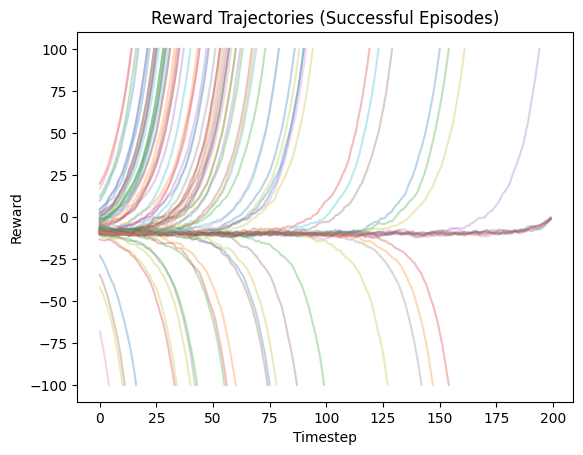

In [21]:
#print(sum(episode_max_step))
plot_episodes = np.logical_or(episode_success, np.logical_or(episode_max_step, episode_collision))
#plot_episodes = np.logical_or(episode_success,episode_collision)
#plot_episodes = episode_success
#plot_episodes = episode_collision
#plot_episodes= episode_max_step

plot_value = episode_z_mc

plt.figure()
for ep in np.where(plot_episodes)[0]:
    plt.plot(plot_value[ep], alpha=0.3)
plt.xlabel("Timestep")
plt.ylabel("Reward")
#plt.ylim(-2,1)
#plt.xlim(0,40)
plt.title("Reward Trajectories (Successful Episodes)")
plt.show()

# Training Plots

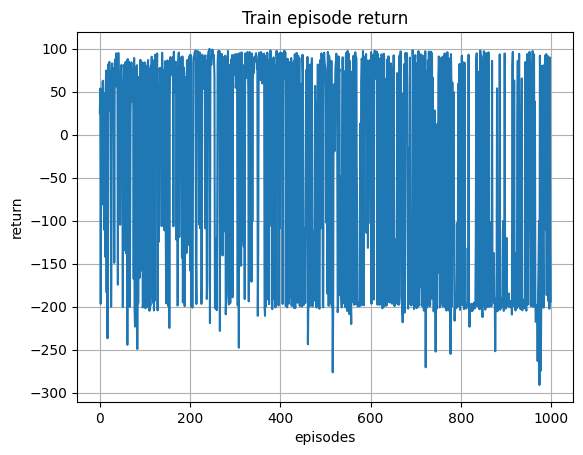

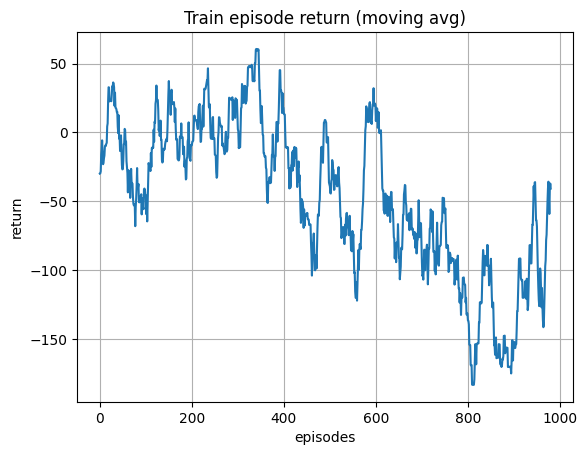

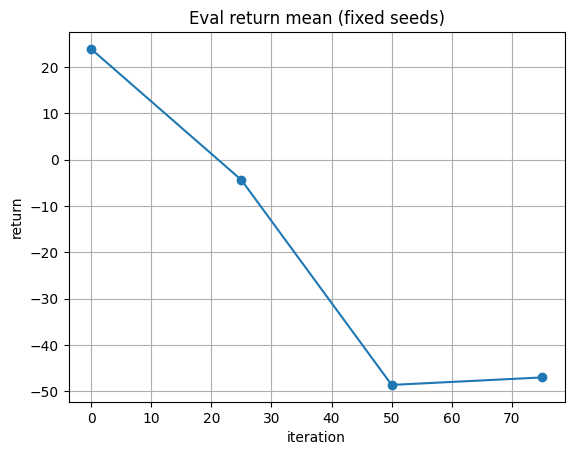

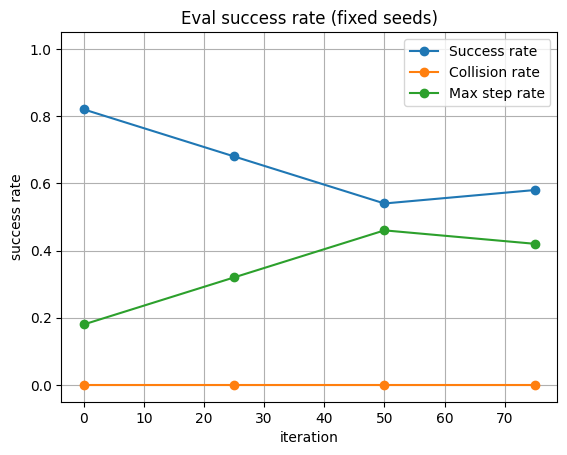

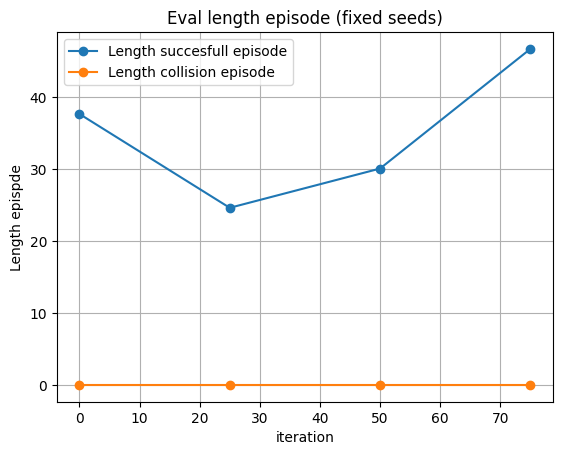

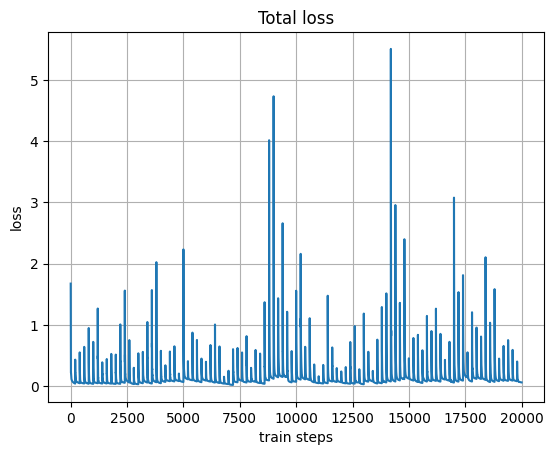

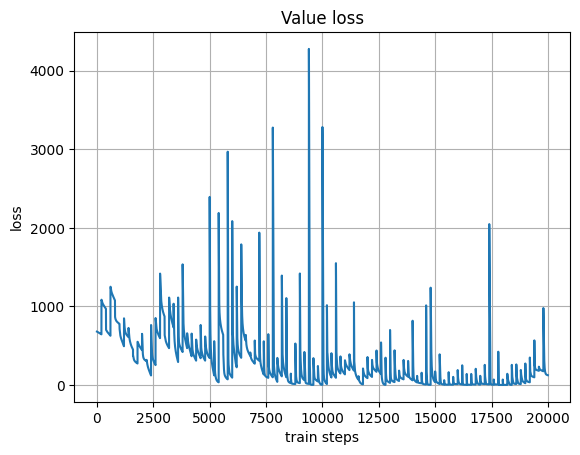

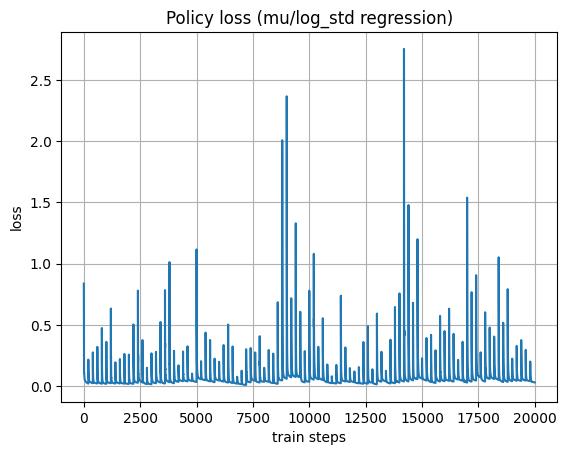

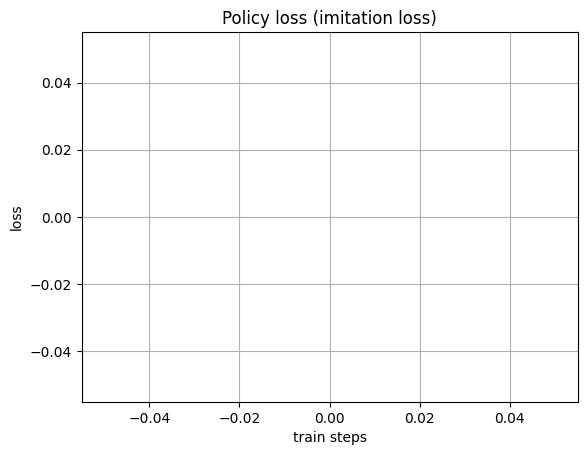

In [22]:
def moving_avg(x, w=20):
    x = np.asarray(x, dtype=float)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

# Train return moving average
plt.figure()
plt.plot(logs["ep_return"])
plt.title("Train episode return")
plt.xlabel("episodes")
plt.ylabel("return")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(moving_avg(logs["ep_return"], w=20))
plt.title("Train episode return (moving avg)")
plt.xlabel("episodes")
plt.ylabel("return")
plt.grid(True)
plt.show()

# Eval return mean
if logs["eval_return_mean"]:
    #print(logs["eval_return_mean"])
    plt.figure()
    plt.plot(logs["iter_idx_eval"], logs["eval_return_mean"], marker="o")
    plt.title("Eval return mean (fixed seeds)")
    plt.xlabel("iteration")
    plt.ylabel("return")
    plt.grid(True)
    plt.show()

# Eval success rate
if logs["success_rate"]:
    #print(logs["success_rate"])
    plt.figure()
    plt.plot(logs["iter_idx_eval"], logs["success_rate"], marker="o", label="Success rate")
    plt.plot(logs["iter_idx_eval"], logs["collision_rate"], marker="o", label="Collision rate")
    plt.plot(logs["iter_idx_eval"], logs["max_step_rate"], marker="o", label="Max step rate")
    plt.title("Eval success rate (fixed seeds)")
    plt.xlabel("iteration")
    plt.ylabel("success rate")
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.grid(True)
    plt.show()

if logs["eval_length_succes"]:
    plt.figure()
    plt.plot(logs["iter_idx_eval"], logs["eval_length_succes"], marker="o", label = "Length succesfull episode")
    plt.plot(logs["iter_idx_eval"], logs["eval_length_collision"], marker="o", label = "Length collision episode")
    plt.title("Eval length episode (fixed seeds)")
    plt.xlabel("iteration")
    plt.ylabel("Length epispde")
    plt.legend()
    plt.grid(True)
    plt.show()

# Losses
if logs["loss_total"]:
    plt.figure()
    plt.plot(logs["loss_total"])
    plt.title("Total loss")
    plt.xlabel("train steps")
    plt.ylabel("loss")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(logs["loss_value"])
    plt.title("Value loss")
    plt.xlabel("train steps")
    plt.ylabel("loss")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(logs["loss_policy"])
    plt.title("Policy loss (mu/log_std regression)")
    plt.xlabel("train steps")
    plt.ylabel("loss")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(logs["loss_policy_distill"])
    plt.title("Policy loss (imitation loss)")
    plt.xlabel("train steps")
    plt.ylabel("loss")
    plt.grid(True)
    plt.show()
    

# Other stuff

In [23]:
"""
num_iters = 30  # start with 30; increase later

# Add eval logs
logs.setdefault("eval_return_mean", [])
logs.setdefault("eval_return_std", [])
logs.setdefault("eval_length_mean", [])
logs.setdefault("success_rate", [])
logs.setdefault("collision_rate", [])
logs.setdefault("iter_idx_eval", [])

# Simple schedules: start clean
def lambda_gauss(iter_idx: int) -> float:
    return 0.0  # baseline: off

def value_mix(iter_idx: int):
    return 1.0, 0.0  # baseline: use z_mcts only


for it in range(num_iters):
    # tell planner what outer iteration we are in
    planner.set_training_iter(it)

    # --- Collect episodes ---
    ep_returns = []
    ep_lengths = []
    for _ in range(cfg.collect_episodes_per_iter):
        stats, _ = collect_one_episode_hybrid(
            env_real=env_real,
            planner=planner,
            replay_buffer=replay,
            max_steps=cfg.max_episode_steps,
            gamma=cfg.gamma,
            training=True,
        )
        ep_returns.append(stats["return"])
        ep_lengths.append(stats["length"])
        logs["ep_return"].append(stats["return"])
        logs["ep_length"].append(stats["length"])

    # --- Train ---
    if len(replay) >= cfg.batch_size:
        w_mcts, w_mc = value_mix(it)
        w_gauss = lambda_gauss(it)

        for _ in range(cfg.train_steps_per_iter):
            batch = replay.sample(cfg.batch_size, device=device, rng=np.random.default_rng(SEED))
            loss_dict = train_step_hybrid(
                net=net,
                optimizer=optimizer,
                batch=batch,
                w_value_mcts=w_mcts * cfg.value_loss_weight,
                w_value_mc=w_mc * cfg.value_loss_weight,
                w_policy_imitation=cfg.policy_loss_weight,
                w_gaussian_reg=w_gauss * cfg.policy_loss_weight,
                grad_clip_norm=1.0,
            )
            for k, v in loss_dict.items():
                logs[k].append(v)

    # --- Eval (fixed seeds) ---
    if (it % cfg.eval_every) == 0:
        eval_stats = run_eval_episodes(
            env_eval=env_eval,
            planner=planner,
            seeds=EVAL_SEEDS,
            max_steps=cfg.max_episode_steps,
            goal_reward=env_eval._goal_reward,
            collision_reward=env_eval._collision_reward,
        )
        logs["iter_idx_eval"].append(it)
        logs["eval_return_mean"].append(eval_stats["eval_return_mean"])
        logs["eval_return_std"].append(eval_stats["eval_return_std"])
        logs["eval_length_mean"].append(eval_stats["eval_length_mean"])
        logs["success_rate"].append(eval_stats["success_rate"])
        logs["collision_rate"].append(eval_stats["collision_rate"])

        print(
            f"[Eval it={it}] "
            f"R={eval_stats['eval_return_mean']:.2f}±{eval_stats['eval_return_std']:.2f} "
            f"len={eval_stats['eval_length_mean']:.1f} "
            f"succ={eval_stats['success_rate']:.2f} "
            f"coll={eval_stats['collision_rate']:.2f}"
        )

    last_loss = logs["loss_total"][-1] if logs["loss_total"] else None
    print(
        f"Iter {it} | replay={len(replay)} | "
        f"train_return_mean={np.mean(ep_returns):.2f} | "
        f"last_loss={last_loss}"
    )
"""

'\nnum_iters = 30  # start with 30; increase later\n\n# Add eval logs\nlogs.setdefault("eval_return_mean", [])\nlogs.setdefault("eval_return_std", [])\nlogs.setdefault("eval_length_mean", [])\nlogs.setdefault("success_rate", [])\nlogs.setdefault("collision_rate", [])\nlogs.setdefault("iter_idx_eval", [])\n\n# Simple schedules: start clean\ndef lambda_gauss(iter_idx: int) -> float:\n    return 0.0  # baseline: off\n\ndef value_mix(iter_idx: int):\n    return 1.0, 0.0  # baseline: use z_mcts only\n\n\nfor it in range(num_iters):\n    # tell planner what outer iteration we are in\n    planner.set_training_iter(it)\n\n    # --- Collect episodes ---\n    ep_returns = []\n    ep_lengths = []\n    for _ in range(cfg.collect_episodes_per_iter):\n        stats, _ = collect_one_episode_hybrid(\n            env_real=env_real,\n            planner=planner,\n            replay_buffer=replay,\n            max_steps=cfg.max_episode_steps,\n            gamma=cfg.gamma,\n            training=True,\n   